In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import gc
import json
import os
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append("../util")
from feature_engineering import lag_feature

In [3]:
input_path = Path('/content/drive/MyDrive/Data_Competitions/SIGIR2021/')

In [5]:
SessionId = 'SessionId'

### Train

In [8]:
%%time
train = pd.read_csv(input_path / 'browsing_train.csv')

print(train.shape)
train.head()

(36079307, 6)
CPU times: user 57.8 s, sys: 8.54 s, total: 1min 6s
Wall time: 1min 26s


In [9]:
train.dtypes

session_id_hash              object
event_type                   object
product_action               object
product_sku_hash             object
server_timestamp_epoch_ms     int64
hashed_url                   object
dtype: object

In [10]:
search = pd.read_csv(input_path / 'search_train.csv')

In [11]:
print(search.shape)
search.head()

(819516, 5)


,session_id_hash,query_vector,clicked_skus_hash,product_skus_hash,server_timestamp_epoch_ms
0,48fade624d47870058ce07dd789ccc04e46c70c0fa2a1b...,"[-0.20255649089813232, -0.016908567398786545, ...",NaN,NaN,1548575194779
1,8731ca84ff7bb8cb647531d54e64feedb2519b4a7792a7...,"[-0.007610442116856575, -0.14909175038337708, ...",NaN,['9ee9ffd7e2529a65f9a0b0c9eaae6330df85cf2e3af3...,1548276763869
2,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.20023074746131897, -0.03151938319206238, 0...",NaN,['7cc72dbed53bab78ec6a62feaa5052a7a1db7d201664...,1548937997295
3,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.18556387722492218, -0.07620412111282349, 0...",NaN,['62c4ddab6c1c81c74d315376b3c0dc7768c0286b3dc6...,1548938038268
4,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.03269264101982117, -0.27234694361686707, 0...",NaN,['2a0ee2924feabeec35e21e8fcb4d5b0684d190e46cef...,1548938093827


In [13]:
search['is_search'] = True

In [14]:
train['is_search'] = False

In [15]:
del search['clicked_skus_hash'], search['product_skus_hash'], search['query_vector']

In [16]:
gc.collect()

61

In [17]:
train_all = pd.concat([train, search], sort=False)

In [18]:
print(train_all.shape)
train_all.head()

(36898823, 7)


,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search
0,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885210881,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...,False
1,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,61ef3869355b78e11011f39fc7ac8f8dfb209b3442a9d5...,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...,False
2,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...,False
3,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...,False
4,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...,False


In [20]:
train_all = train_all.reset_index(drop=True)
train_all

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search
0,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885210881,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...,False
1,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,61ef3869355b78e11011f39fc7ac8f8dfb209b3442a9d5...,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...,False
2,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...,False
3,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...,False
4,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...,False
...,...,...,...,...,...,...,...
36898818,9b037012702a2dadee910c6b71b691b6ba072b22f41b7b...,NaN,NaN,NaN,1548987598321,NaN,True
36898819,9b037012702a2dadee910c6b71b691b6ba072b22f41b7b...,NaN,NaN,NaN,1548987688646,NaN,True
36898820,fdf03b124f6cb368c42a9408bc1186e4ea1465cacd5855...,NaN,NaN,NaN,1548554188376,NaN,True
36898821,fdf03b124f6cb368c42a9408bc1186e4ea1465cacd5855...,NaN,NaN,NaN,1548554908239,NaN,True


In [21]:
del train, search

In [22]:
gc.collect()

633

### Test

In [25]:
test_rec_out = pd.read_csv(input_path / 'test_rec_stage2.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
test_intent_out =pd.read_csv(input_path / 'test_intent_stage2.csv', index_col=0)

In [27]:
test_intent_df = pd.read_csv(input_path / 'test_intent.csv', index_col=0)
test_intent_df

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,product_skus_hash,clicked_skus_hash,is_search,query_vector
0,0,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,NaN,NaN,False,NaN
1,0,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,NaN,NaN,False,NaN
2,0,event_product,add,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250476776,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,NaN,NaN,False,NaN
3,1,NaN,NaN,NaN,1557259563467,NaN,['cdcfae35b9136964fffa164db83293bc22ccc5cb8572...,NaN,True,"[0.0711296796798706, 0.3248276710510254, 0.023..."
4,1,NaN,NaN,NaN,1557259580980,NaN,['2d56a573739252332916de9219adfa0cf4e33c306c03...,NaN,True,"[-0.1051841750741005, 0.05710870400071144, -0...."
...,...,...,...,...,...,...,...,...,...,...
199805,20754,pageview,NaN,NaN,1557768205489,41ae0f916406434064aeb03d859a7141b53d2900394dca...,NaN,NaN,False,NaN
199806,20754,event_product,add,2effcad603464997036e289e5d03fd06da1591e58b4d85...,1557768222014,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,NaN,NaN,False,NaN
199807,20755,event_product,detail,5ce18fb32bc0193361f007299ac57e33df3c80daed5518...,1555610212436,c304bac657210bbd188136f4e7fc2f28c778cb472e880e...,NaN,NaN,False,NaN
199808,20755,event_product,detail,5ce18fb32bc0193361f007299ac57e33df3c80daed5518...,1555610245670,c304bac657210bbd188136f4e7fc2f28c778cb472e880e...,NaN,NaN,False,NaN


In [28]:
test = pd.read_csv(input_path / 'browsing_test_all.csv', index_col=0)
test = test.rename(columns={'session_id': 'session_id_hash'})
test

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,product_skus_hash,clicked_skus_hash,is_search,query_vector
0,0,event_product,detail,4641de8468a39c53a151e8ee5f3bd731e69b3d7ac61335...,1557432435044,4f7f239c607d10b0843ceeccb98aecb382f8c18a931758...,NaN,NaN,False,NaN
1,1,event_product,detail,7571fbadb886e669ea4ac666b585fcc798c1f5970867c5...,1555443439867,0301401ac53e67e319036bbb0c12a4715ec5df45614023...,NaN,NaN,False,NaN
2,2,pageview,NaN,NaN,1556729588695,9cfe9b259c3c4029a5d20e3542905d07ccf50d9a3bd4d7...,NaN,NaN,False,NaN
3,3,NaN,NaN,NaN,1557259563467,NaN,['cdcfae35b9136964fffa164db83293bc22ccc5cb8572...,NaN,True,"[0.0711296796798706, 0.3248276710510254, 0.023..."
4,3,NaN,NaN,NaN,1557259580980,NaN,['2d56a573739252332916de9219adfa0cf4e33c306c03...,NaN,True,"[-0.1051841750741005, 0.05710870400071144, -0...."
...,...,...,...,...,...,...,...,...,...,...
576430,142324,pageview,NaN,NaN,1557406201853,41ae0f916406434064aeb03d859a7141b53d2900394dca...,NaN,NaN,False,NaN
576431,142324,event_product,detail,a1d1d5f08b46a3f88d51e0a025c8d9efc7d670f2d5a974...,1557406412461,a71936368619e41471e8aa88c44a73b24d3dec3fe1b9b6...,NaN,NaN,False,NaN
576432,142324,event_product,detail,4e880bf467dcb699fd61519bc3845dd6524b2095d45e7f...,1557406442986,c3eb53ea31db5ba124449624561969376aceb63297ce18...,NaN,NaN,False,NaN
576433,142325,event_product,detail,3a62198d671b861ee178dd025f321ac66c28ba2e6967c6...,1557337655966,d4bb262e543866324b517cf4e294c77d270cfabe5d5f4f...,NaN,NaN,False,NaN


concatenate dfs in the order of test_rec_out, test, test_intent_out, and test_intent_df.

In [29]:
test['session_id_hash'] += (test_rec_out['session_id_hash'].max() + 1)
test_intent_out['session_id_hash'] += (test['session_id_hash'].max() + 1)
test_intent_df['session_id_hash'] += (test_intent_out['session_id_hash'].max() + 1)

In [30]:
test_rec_out

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,product_skus_hash,clicked_skus_hash,is_search,query_vector
0,0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,NaN,NaN,False,NaN
1,1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,NaN,NaN,False,NaN
2,1,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,NaN,NaN,False,NaN
3,2,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,NaN,NaN,False,NaN
4,2,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...
1342646,332245,event_product,detail,527fe77d65a94b2994c6d5a4c0255804a7f11118e87033...,1557369241429,b09f7ea3d74c95acf0f548ba2d6419e24af56fe5aa36c5...,NaN,NaN,False,NaN
1342647,332245,event_product,detail,695ea038afc9ce9917ee7a5da11376187261e5b46aee6b...,1557369275425,5331d77a5d9afcdd593698bb2ac61c4a85f41c6f7645ab...,NaN,NaN,False,NaN
1342648,332245,event_product,detail,05f67e6804322bfdaf46caf04ef0be5386ec85d487e0db...,1557369282615,351b74fd01e1b7a5a77bf8c8b6786ae48dbb2401ed28bd...,NaN,NaN,False,NaN
1342649,332245,event_product,detail,2c9afec211078e452b88ee9997997c7cf1225efad9adf8...,1557369290441,5f683df0f7f46f055518baab8ab64561926245a87c1f9c...,NaN,NaN,False,NaN


In [31]:
test

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,product_skus_hash,clicked_skus_hash,is_search,query_vector
0,332247,event_product,detail,4641de8468a39c53a151e8ee5f3bd731e69b3d7ac61335...,1557432435044,4f7f239c607d10b0843ceeccb98aecb382f8c18a931758...,NaN,NaN,False,NaN
1,332248,event_product,detail,7571fbadb886e669ea4ac666b585fcc798c1f5970867c5...,1555443439867,0301401ac53e67e319036bbb0c12a4715ec5df45614023...,NaN,NaN,False,NaN
2,332249,pageview,NaN,NaN,1556729588695,9cfe9b259c3c4029a5d20e3542905d07ccf50d9a3bd4d7...,NaN,NaN,False,NaN
3,332250,NaN,NaN,NaN,1557259563467,NaN,['cdcfae35b9136964fffa164db83293bc22ccc5cb8572...,NaN,True,"[0.0711296796798706, 0.3248276710510254, 0.023..."
4,332250,NaN,NaN,NaN,1557259580980,NaN,['2d56a573739252332916de9219adfa0cf4e33c306c03...,NaN,True,"[-0.1051841750741005, 0.05710870400071144, -0...."
...,...,...,...,...,...,...,...,...,...,...
576430,474571,pageview,NaN,NaN,1557406201853,41ae0f916406434064aeb03d859a7141b53d2900394dca...,NaN,NaN,False,NaN
576431,474571,event_product,detail,a1d1d5f08b46a3f88d51e0a025c8d9efc7d670f2d5a974...,1557406412461,a71936368619e41471e8aa88c44a73b24d3dec3fe1b9b6...,NaN,NaN,False,NaN
576432,474571,event_product,detail,4e880bf467dcb699fd61519bc3845dd6524b2095d45e7f...,1557406442986,c3eb53ea31db5ba124449624561969376aceb63297ce18...,NaN,NaN,False,NaN
576433,474572,event_product,detail,3a62198d671b861ee178dd025f321ac66c28ba2e6967c6...,1557337655966,d4bb262e543866324b517cf4e294c77d270cfabe5d5f4f...,NaN,NaN,False,NaN


In [32]:
test_intent_out

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,product_skus_hash,clicked_skus_hash,is_search,query_vector
0,474574,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,NaN,NaN,False,NaN
1,474574,event_product,detail,6f456eac528ebe8299c4b01b893f89312a60254b05fbf4...,1557247660313,e4b7a27d4b644307b4e6eafdf7e01c2a1af2b82979cdc4...,NaN,NaN,False,NaN
2,474574,event_product,add,6f456eac528ebe8299c4b01b893f89312a60254b05fbf4...,1557247744887,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,NaN,NaN,False,NaN
3,474575,event_product,detail,f79f6827292671073a959fc23b32ede49033d4c94ba011...,1556406323469,530768ccee031e2d66187c0351d107d2d9972b1d5e8053...,NaN,NaN,False,NaN
4,474575,event_product,detail,f79f6827292671073a959fc23b32ede49033d4c94ba011...,1556406398328,530768ccee031e2d66187c0351d107d2d9972b1d5e8053...,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...
461092,522283,pageview,NaN,NaN,1557526477847,373f7439d204f4f48ef3ee3eea08ebfba922267d9ce027...,NaN,NaN,False,NaN
461093,522283,NaN,NaN,NaN,1557526486324,NaN,['acbd4c4648a2ba933f47ae5ce99ad290ec2923764da1...,['ba942bf95109b5753aad1454a24fddc4e96f5912390d...,True,"[0.09662579745054245, 0.17918941378593445, -0...."
461094,522283,pageview,NaN,NaN,1557526488362,41ae0f916406434064aeb03d859a7141b53d2900394dca...,NaN,NaN,False,NaN
461095,522283,event_product,add,ba942bf95109b5753aad1454a24fddc4e96f5912390d79...,1557526530087,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,NaN,NaN,False,NaN


In [33]:
test_intent_df

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,product_skus_hash,clicked_skus_hash,is_search,query_vector
0,522285,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,NaN,NaN,False,NaN
1,522285,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,NaN,NaN,False,NaN
2,522285,event_product,add,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250476776,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,NaN,NaN,False,NaN
3,522286,NaN,NaN,NaN,1557259563467,NaN,['cdcfae35b9136964fffa164db83293bc22ccc5cb8572...,NaN,True,"[0.0711296796798706, 0.3248276710510254, 0.023..."
4,522286,NaN,NaN,NaN,1557259580980,NaN,['2d56a573739252332916de9219adfa0cf4e33c306c03...,NaN,True,"[-0.1051841750741005, 0.05710870400071144, -0...."
...,...,...,...,...,...,...,...,...,...,...
199805,543039,pageview,NaN,NaN,1557768205489,41ae0f916406434064aeb03d859a7141b53d2900394dca...,NaN,NaN,False,NaN
199806,543039,event_product,add,2effcad603464997036e289e5d03fd06da1591e58b4d85...,1557768222014,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,NaN,NaN,False,NaN
199807,543040,event_product,detail,5ce18fb32bc0193361f007299ac57e33df3c80daed5518...,1555610212436,c304bac657210bbd188136f4e7fc2f28c778cb472e880e...,NaN,NaN,False,NaN
199808,543040,event_product,detail,5ce18fb32bc0193361f007299ac57e33df3c80daed5518...,1555610245670,c304bac657210bbd188136f4e7fc2f28c778cb472e880e...,NaN,NaN,False,NaN


In [34]:
for c in ['clicked_skus_hash', 'product_skus_hash', 'query_vector']:
    del test[c], test_intent_df[c], test_intent_out[c], test_rec_out[c]

In [35]:
gc.collect()

285

In [36]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073        9977         247           1       15848       21015
Swap:             0           0           0


### Concatenate

In [37]:
train_all['is_test'] = 0
test['is_test'] = 0
test_intent_df['is_test'] = 0
test_rec_out['is_test'] = 1
test_intent_out['is_test'] = 0
all_df = pd.concat([test_rec_out, test, test_intent_out, test_intent_df, train_all], sort=False)
all_df

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test
0,0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1
1,1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1
2,1,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1
3,2,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1
4,2,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1
...,...,...,...,...,...,...,...,...
36898818,9b037012702a2dadee910c6b71b691b6ba072b22f41b7b...,NaN,NaN,NaN,1548987598321,NaN,True,0
36898819,9b037012702a2dadee910c6b71b691b6ba072b22f41b7b...,NaN,NaN,NaN,1548987688646,NaN,True,0
36898820,fdf03b124f6cb368c42a9408bc1186e4ea1465cacd5855...,NaN,NaN,NaN,1548554188376,NaN,True,0
36898821,fdf03b124f6cb368c42a9408bc1186e4ea1465cacd5855...,NaN,NaN,NaN,1548554908239,NaN,True,0


In [38]:
del train_all, test_rec_out, test, test_intent_df, test_intent_out

In [39]:
gc.collect()

255

### session id

In [40]:
all_df[SessionId] = all_df.groupby([all_df.session_id_hash]).grouper.group_info[0]

In [41]:
all_df

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId
0,0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0
1,1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1
2,1,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1
3,2,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2
4,2,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2
...,...,...,...,...,...,...,...,...,...
36898818,9b037012702a2dadee910c6b71b691b6ba072b22f41b7b...,NaN,NaN,NaN,1548987598321,NaN,True,0,3577699
36898819,9b037012702a2dadee910c6b71b691b6ba072b22f41b7b...,NaN,NaN,NaN,1548987688646,NaN,True,0,3577699
36898820,fdf03b124f6cb368c42a9408bc1186e4ea1465cacd5855...,NaN,NaN,NaN,1548554188376,NaN,True,0,5513320
36898821,fdf03b124f6cb368c42a9408bc1186e4ea1465cacd5855...,NaN,NaN,NaN,1548554908239,NaN,True,0,5513320


In [42]:
del all_df['session_id_hash']

In [43]:
gc.collect()

103

In [44]:
%%time
all_df.to_csv(input_path / 'product_train_test_stage2.csv', index=False)

CPU times: user 2min 30s, sys: 4.59 s, total: 2min 35s
Wall time: 3min 40s


## To extract popular items

In [ ]:
all_df = all_df[all_df['event_type'] == 'event_product']

In [ ]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1
8,event_product,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2
10,event_product,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,False,1,2
...,...,...,...,...,...,...,...,...
36079292,event_product,detail,fbdfbd3ead2eea0b54bba77e87f920c7ffd071dd13b9ce...,1552162037373,f99dd8d9426d6e6cddaabd1d90b0a815606a44c465117d...,False,0,669773
36079295,event_product,detail,c0dc796d30424b4434a0922bd7c7675c955e9821c059d1...,1552162119268,a377a877cd396a3fef920104bb44b56f7a980ff4362e5d...,False,0,669773
36079297,event_product,add,c0dc796d30424b4434a0922bd7c7675c955e9821c059d1...,1552162139205,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,False,0,669773
36079298,event_product,add,c0dc796d30424b4434a0922bd7c7675c955e9821c059d1...,1552162148035,83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...,False,0,669773


In [ ]:
del all_df['event_type'], all_df['hashed_url'], all_df['server_timestamp_epoch_ms'], all_df['is_search']

In [ ]:
all_df

,product_action,product_sku_hash,is_test,SessionId
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1,0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1,1
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1,1
8,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1,2
10,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1,2
...,...,...,...,...
36079292,detail,fbdfbd3ead2eea0b54bba77e87f920c7ffd071dd13b9ce...,0,669773
36079295,detail,c0dc796d30424b4434a0922bd7c7675c955e9821c059d1...,0,669773
36079297,add,c0dc796d30424b4434a0922bd7c7675c955e9821c059d1...,0,669773
36079298,add,c0dc796d30424b4434a0922bd7c7675c955e9821c059d1...,0,669773


In [ ]:
%%time
all_df.to_csv(input_path / 'only_product_train_test_stage2.csv', index=False)

CPU times: user 34.5 s, sys: 1.05 s, total: 35.5 s
Wall time: 40.2 s


### length features

In [8]:
%%time
all_df = pd.read_csv(input_path / 'product_train_test_stage2.csv')

<string>:2: DtypeWarning: Columns (0,1,2,4) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 45.1 s, sys: 5.72 s, total: 50.8 s
Wall time: 57.8 s


In [9]:
%%time
all_df = all_df.sort_values(['SessionId', 'server_timestamp_epoch_ms', 'event_type', 'product_action'])

CPU times: user 1min 15s, sys: 1.33 s, total: 1min 17s
Wall time: 1min 16s


In [10]:
all_df['last_event_time'] = lag_feature(all_df, SessionId, 'server_timestamp_epoch_ms', 1, np.nan)

In [11]:
gc.collect()

105

In [12]:
all_df[:20]

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_time
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,NaN
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,NaN
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,1.556250e+12
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,NaN
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,1.556995e+12
5,pageview,NaN,NaN,1556994807574,19bb427095c0d5584124249a91eff00b0ad5217b2a13c9...,False,1,2,1.556995e+12
6,pageview,NaN,NaN,1556994812018,b1011496f871ceca47c817a4f2b718a140f18bc3eebe89...,False,1,2,1.556995e+12
7,pageview,NaN,NaN,1556994832963,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,1,2,1.556995e+12
8,event_product,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,1.556995e+12
9,pageview,NaN,NaN,1556994862610,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,1,2,1.556995e+12


In [13]:
all_df['last_event_length'] = all_df['server_timestamp_epoch_ms'] - all_df['last_event_time']

In [14]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_time,last_event_length
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,NaN,NaN
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,NaN,NaN
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,1.556250e+12,34160.0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,NaN,NaN
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,1.556995e+12,9267.0
...,...,...,...,...,...,...,...,...,...,...
33295312,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,1.550719e+12,55768.0
33295311,pageview,NaN,NaN,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,1.550719e+12,0.0
33295313,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,1.550719e+12,29090.0
33295314,pageview,NaN,NaN,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,1.550719e+12,0.0


In [15]:
all_df[all_df['last_event_length']==0]['event_type'].value_counts()

pageview         9764573
event_product      23434
Name: event_type, dtype: int64

In [16]:
all_df['last_hashed_url'] = lag_feature(all_df, SessionId, 'hashed_url', 1, np.nan)
all_df['same_url'] = all_df['last_hashed_url'] == all_df['hashed_url']

In [17]:
all_df = all_df[(all_df['last_event_length'] != 0) | (all_df['event_type'] != 'pageview') | (~all_df['same_url'])]
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_time,last_event_length,last_hashed_url,same_url
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,NaN,NaN,NaN,False
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,NaN,NaN,NaN,False
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,1.556250e+12,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,NaN,NaN,NaN,False
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,1.556995e+12,9267.0,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
33295308,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.550719e+12,18765.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True
33295310,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,1.550719e+12,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False
33295312,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,1.550719e+12,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False
33295313,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,1.550719e+12,29090.0,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False


In [18]:
all_df = all_df.reset_index(drop=True)

In [19]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_time,last_event_length,last_hashed_url,same_url
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,NaN,NaN,NaN,False
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,NaN,NaN,NaN,False
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,1.556250e+12,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,NaN,NaN,NaN,False
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,1.556995e+12,9267.0,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.550719e+12,18765.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,1.550719e+12,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,1.550719e+12,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,1.550719e+12,29090.0,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False


In [20]:
all_df['last_event_length'].min(), all_df['last_event_length'].max() 

(0.0, 8224794.0)

In [21]:
all_df['last_event_length'].isnull().sum()

5553723

In [22]:
med = all_df['last_event_length'].median()
mean = all_df['last_event_length'].mean()
med, mean

(14273.0, 46910.98464692374)

In [23]:
# fill nans with the average length for each session
tmp_df = all_df.groupby(SessionId).last_event_length.mean().reset_index()
all_df.loc[all_df['last_event_length'].isnull(), 'last_event_length'] = tmp_df['last_event_length'].values

In [24]:
tmp_df

,SessionId,last_event_length
0,0,NaN
1,1,34160.000000
2,2,17019.230769
3,3,386196.500000
4,4,NaN
...,...,...
5553718,5553718,NaN
5553719,5553719,6765.600000
5553720,5553720,29429.000000
5553721,5553721,73618.000000


In [25]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_time,last_event_length,last_hashed_url,same_url
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,NaN,NaN,NaN,False
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,NaN,3.416000e+04,NaN,False
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,1.556250e+12,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,NaN,1.701923e+04,NaN,False
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,1.556995e+12,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.550719e+12,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,1.550719e+12,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,1.550719e+12,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,1.550719e+12,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False


In [26]:
all_df['last_event_length'].isnull().sum()

2399476

In [27]:
all_df['last_event_length'].median(), all_df['last_event_length'].mean()

(15635.0, 49098.88651680272)

In [28]:
# fill nans with the original median
all_df.loc[all_df['last_event_length'].isnull(), 'last_event_length'] = med

In [29]:
all_df['last_event_length'].median(), all_df['last_event_length'].mean()

(14273.0, 46286.77027492041)

In [30]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_time,last_event_length,last_hashed_url,same_url
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,NaN,1.427300e+04,NaN,False
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,NaN,3.416000e+04,NaN,False
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,1.556250e+12,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,NaN,1.701923e+04,NaN,False
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,1.556995e+12,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.550719e+12,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,1.550719e+12,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,1.550719e+12,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,1.550719e+12,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False


In [31]:
del all_df['last_event_time']

In [32]:
gc.collect()

320

### event count

In [33]:
all_df['pageview'] = all_df['event_type'] == 'pageview'

In [34]:
all_df['cum_pageview'] = all_df.groupby([SessionId])['pageview'].cumsum()

In [35]:
all_df[:30]

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2
5,pageview,NaN,NaN,1556994807574,19bb427095c0d5584124249a91eff00b0ad5217b2a13c9...,False,1,2,7.098000e+03,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,True,3
6,pageview,NaN,NaN,1556994812018,b1011496f871ceca47c817a4f2b718a140f18bc3eebe89...,False,1,2,4.444000e+03,19bb427095c0d5584124249a91eff00b0ad5217b2a13c9...,False,True,4
7,pageview,NaN,NaN,1556994832963,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,1,2,2.094500e+04,b1011496f871ceca47c817a4f2b718a140f18bc3eebe89...,False,True,5
8,event_product,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,2.460100e+04,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,5
9,pageview,NaN,NaN,1556994862610,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,1,2,5.046000e+03,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,True,6


In [36]:
gc.collect()

201

In [37]:
all_df['product'] = all_df['event_type'] == 'event_product'
all_df['cum_product'] = all_df.groupby([SessionId])['product'].cumsum()
del all_df['product']

In [38]:
gc.collect()

132

In [39]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12


In [40]:
all_df['cum_search'] = all_df.groupby([SessionId])['is_search'].cumsum()

In [41]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9,0
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12,0


In [42]:
gc.collect()

159

In [43]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073       15523         221           1       10327       20527
Swap:             0           0           0


In [44]:
%%time
all_df.to_csv(input_path / 'product_train_and_test_3.csv', index=False)

CPU times: user 3min 36s, sys: 11.8 s, total: 3min 48s
Wall time: 4min 18s


# RELOAD

In [7]:
%%time
all_df = pd.read_csv(input_path / 'product_train_and_test_3.csv')

CPU times: user 1min 19s, sys: 9.5 s, total: 1min 28s
Wall time: 1min 42s


In [8]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073       10608         245           1       15219       20705
Swap:             0           0           0


### lapse

In [9]:
all_df['cum_event'] = all_df['cum_pageview'] + all_df['cum_product'] + all_df['cum_search']

In [10]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0,1
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0,1
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0,1
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9,0,26
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12,0,29


In [11]:
%%time
tmp_df = all_df[all_df['cum_event']==1][[SessionId, 'server_timestamp_epoch_ms']]
tmp_df.columns = [SessionId, 'first_time']
all_df = all_df.merge(tmp_df, on=SessionId, how='left')
del tmp_df

CPU times: user 15.7 s, sys: 2.86 s, total: 18.6 s
Wall time: 18.4 s


In [12]:
all_df['lapse'] = all_df['server_timestamp_epoch_ms'] - all_df['first_time']

In [13]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0,1,1557247655055,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0,1,1556250432707,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0,1,1556994791209,0
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0,2,1556994791209,9267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9,0,26,1550717835512,699908
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12,0,29,1550717835512,807302


## Late pageviews and searches

In [14]:
tmp = all_df.groupby(SessionId)['pageview'].sum()
tmp = pd.DataFrame(tmp)
tmp = tmp.reset_index(drop=False)
tmp.columns = [SessionId, 'sum_pageview']
tmp

,SessionId,sum_pageview
0,0,0
1,1,0
2,2,10
3,3,4
4,4,0
...,...,...
5553718,5553718,1
5553719,5553719,5
5553720,5553720,0
5553721,5553721,2


In [15]:
all_df = pd.merge(all_df, tmp, how='left', on=SessionId)
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0,1,1557247655055,0,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0,1,1556250432707,0,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0,1,1556994791209,0,10
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0,2,1556994791209,9267,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9,0,26,1550717835512,699908,18
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12,0,29,1550717835512,807302,18


In [16]:
del tmp

In [17]:
gc.collect()

100

In [18]:
tmp = all_df.groupby(SessionId)['is_search'].sum()
tmp = pd.DataFrame(tmp)
tmp = tmp.reset_index(drop=False)
tmp.columns = [SessionId, 'sum_search']
tmp

,SessionId,sum_search
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
5553718,5553718,0
5553719,5553719,0
5553720,5553720,0
5553721,5553721,0


In [19]:
all_df = pd.merge(all_df, tmp, how='left', on=SessionId)
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0,1,1557247655055,0,0,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0,1,1556250432707,0,0,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0,1,1556994791209,0,10,0
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0,2,1556994791209,9267,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9,0,26,1550717835512,699908,18,0
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18,0
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18,0
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12,0,29,1550717835512,807302,18,0


In [20]:
del tmp

In [21]:
gc.collect()

115

In [22]:
all_df['num_late_pageview'] = all_df['sum_pageview'] - all_df['cum_pageview']
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0,1,1556994791209,0,10,0,9
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0,2,1556994791209,9267,10,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9,0,26,1550717835512,699908,18,0,1
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18,0,1
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18,0,1
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12,0,29,1550717835512,807302,18,0,1


In [23]:
all_df['num_late_search'] = all_df['sum_search'] - all_df['cum_search']
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview,num_late_search
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0,0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0,1,1556994791209,0,10,0,9,0
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0,2,1556994791209,9267,10,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715651,pageview,NaN,NaN,1550718535420,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,0,5553722,1.876500e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,True,True,17,9,0,26,1550717835512,699908,18,0,1,0
29715652,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,2.253600e+04,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18,0,1,0
29715653,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,5.576800e+04,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18,0,1,0
29715654,event_product,detail,2b1dd7624847cfe832fb6aaba59834f34008ed2820bca3...,1550718642814,c556502992acafffde649f4fff0748f1fcce22f21f5e02...,False,0,5553722,2.909000e+04,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,False,17,12,0,29,1550717835512,807302,18,0,1,0


In [24]:
all_df[:30]

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview,num_late_search
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,1.427300e+04,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,3.416000e+04,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,3.416000e+04,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0,0
3,pageview,NaN,NaN,1556994791209,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,1,2,1.701923e+04,NaN,False,True,1,0,0,1,1556994791209,0,10,0,9,0
4,pageview,NaN,NaN,1556994800476,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,1,2,9.267000e+03,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...,False,True,2,0,0,2,1556994791209,9267,10,0,8,0
5,pageview,NaN,NaN,1556994807574,19bb427095c0d5584124249a91eff00b0ad5217b2a13c9...,False,1,2,7.098000e+03,199df805067b2151516282e63935b19a1845b93bf2ebbb...,False,True,3,0,0,3,1556994791209,16365,10,0,7,0
6,pageview,NaN,NaN,1556994812018,b1011496f871ceca47c817a4f2b718a140f18bc3eebe89...,False,1,2,4.444000e+03,19bb427095c0d5584124249a91eff00b0ad5217b2a13c9...,False,True,4,0,0,4,1556994791209,20809,10,0,6,0
7,pageview,NaN,NaN,1556994832963,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,1,2,2.094500e+04,b1011496f871ceca47c817a4f2b718a140f18bc3eebe89...,False,True,5,0,0,5,1556994791209,41754,10,0,5,0
8,event_product,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,2.460100e+04,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,5,1,0,6,1556994791209,66355,10,0,5,0
9,pageview,NaN,NaN,1556994862610,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,1,2,5.046000e+03,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,True,6,1,0,7,1556994791209,71401,10,0,4,0


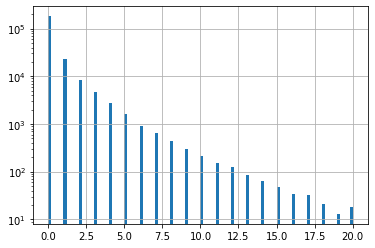

In [25]:
all_df[(all_df['is_test']==1) & (all_df['event_type']=='event_product')].groupby(SessionId).nth(-1)['num_late_pageview'].hist(bins=100, range=(0, 20), log=True)

In [ ]:
all_df[(all_df['is_test']==0) & (all_df['event_type']=='event_product')].groupby(SessionId).nth(-1)['num_late_pageview'].hist(bins=100, range=(0, 20), log=True)

In [25]:
%%time
all_df.to_csv(input_path / 'product_train_and_test_3_1.csv', index=False)

CPU times: user 4min 26s, sys: 6.44 s, total: 4min 32s
Wall time: 4min 56s


### Filter out

In [7]:
%%time
all_df = pd.read_csv(input_path / 'product_train_and_test_3_1.csv')

CPU times: user 1min 21s, sys: 12.8 s, total: 1min 34s
Wall time: 1min 42s


In [8]:
# * rows with null product_sku_hash
all_df = all_df.dropna(subset=['product_sku_hash'])
print(len(all_df))

11585175


In [9]:
all_df = all_df.reset_index(drop=True)

In [10]:
all_df

,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview,num_late_search
0,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,14273.0,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0,0
1,event_product,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,34160.0,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0,0
2,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0,0
3,event_product,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,5,1,0,6,1556994791209,66355,10,0,5,0
4,event_product,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,False,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,6,2,0,8,1556994791209,117944,10,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11585170,event_product,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,False,6,8,0,14,1550717835512,375053,18,0,12,0
11585171,event_product,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,False,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,False,6,9,0,15,1550717835512,414283,18,0,12,0
11585172,event_product,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18,0,1,0
11585173,event_product,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18,0,1,0


In [11]:
# * sessions with only one action in train data
all_df['session_len_count'] = all_df.groupby(SessionId)[SessionId].transform('count')
all_df = all_df[(all_df['session_len_count'] > 1) | (all_df['is_test'] == 1)]
print(len(all_df))

9853698


In [12]:
all_df['event_type'].nunique()

1

In [13]:
del all_df['event_type']

In [14]:
gc.collect()

165

In [15]:
all_df = all_df.reset_index(drop=True)

In [17]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview,num_late_search,session_len_count
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,14273.0,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0,0,1
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,34160.0,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0,0,2
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0,0,2
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,5,1,0,6,1556994791209,66355,10,0,5,0,4
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,False,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,6,2,0,8,1556994791209,117944,10,0,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,False,6,8,0,14,1550717835512,375053,18,0,12,0,12
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,False,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,False,6,9,0,15,1550717835512,414283,18,0,12,0,12
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18,0,1,0,12
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18,0,1,0,12


In [18]:
gc.collect()

318

In [19]:
all_df['cum_product_r'] = all_df['session_len_count'] - all_df['cum_product']

In [20]:
all_df.head(50)

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview,num_late_search,session_len_count,cum_product_r
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,14273.000000,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0,0,1,0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,34160.000000,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0,0,2,1
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,34160.000000,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0,0,2,0
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,24601.000000,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,5,1,0,6,1556994791209,66355,10,0,5,0,4,3
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,False,1,2,46543.000000,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,6,2,0,8,1556994791209,117944,10,0,4,0,4,2
5,detail,3823c0ae0866a92c93c18ba4af63169128edb0cd679aff...,1556994956133,114ddc7d0381a98d20822be88a90754345d836fb89c8e7...,False,1,2,13611.000000,22c1ce2d23943c5180f95685abe9b0ce6d2046a6586c18...,False,False,8,3,0,11,1556994791209,164924,10,0,2,0,4,1
6,detail,004c3e96a1e3b86eb6ede94f2745a5d3062eab6b62f1a7...,1556995004703,2f19e0f9b5f48dbb6af2d9d0113eca9401807da88e268d...,False,1,2,38926.000000,22c1ce2d23943c5180f95685abe9b0ce6d2046a6586c18...,False,False,9,4,0,13,1556994791209,213494,10,0,1,0,4,0
7,detail,fa2f22b63f20f974310deec8da2c76b6fb0057683a0cea...,1557242454646,56cd97d94a4bd9f558d2a816e8ae23ceffe36b0b99ed44...,False,1,3,138730.000000,e86ece8316914c06fbf05515e1e0b68e8dc5bac78c5550...,False,False,4,1,0,5,1557240909860,1544786,4,0,0,0,1,0
8,detail,409308a78b45af2d988eef583eb35a80cb5c89f294f771...,1556213646282,61b436fd7cccddb68485f7d0825d1c9d0dec0a1b49f7c6...,False,1,4,14273.000000,NaN,False,False,0,1,0,1,1556213646282,0,0,0,0,0,1,0
9,detail,3c96575eab701b1a4d99d1a8718f115eb27fd51c7e3f77...,1556500169186,88147d2784a8fc1c8f8acf5abec09975f7c9cbaff68d56...,False,1,5,14273.000000,NaN,False,False,0,1,0,1,1556500169186,0,0,0,0,0,1,0


In [21]:
# after removing the pageviews
all_df['num_late_search_next'] = lag_feature(all_df, SessionId, 'num_late_search', -1, 0)
all_df['num_late_pageview_next'] = lag_feature(all_df, SessionId, 'num_late_pageview', -1, 0)

In [22]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview,num_late_search,session_len_count,cum_product_r,num_late_search_next,num_late_pageview_next
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,14273.0,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0,0,1,0,0.0,0.0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,34160.0,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0,0,2,1,0.0,0.0
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0,0,2,0,0.0,0.0
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,5,1,0,6,1556994791209,66355,10,0,5,0,4,3,0.0,4.0
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,False,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,6,2,0,8,1556994791209,117944,10,0,4,0,4,2,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,False,6,8,0,14,1550717835512,375053,18,0,12,0,12,4,0.0,12.0
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,False,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,False,6,9,0,15,1550717835512,414283,18,0,12,0,12,3,0.0,1.0
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18,0,1,0,12,2,0.0,1.0
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18,0,1,0,12,1,0.0,1.0


In [23]:
all_df['num_following_search'] = all_df['num_late_search'] - all_df['num_late_search_next']
all_df['num_following_pageview'] = all_df['num_late_pageview'] - all_df['num_late_pageview_next']

In [24]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_search,is_test,SessionId,last_event_length,last_hashed_url,same_url,pageview,cum_pageview,cum_product,cum_search,cum_event,first_time,lapse,sum_pageview,sum_search,num_late_pageview,num_late_search,session_len_count,cum_product_r,num_late_search_next,num_late_pageview_next,num_following_search,num_following_pageview
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,False,1,0,14273.0,NaN,False,False,0,1,0,1,1557247655055,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,1,1,34160.0,NaN,False,False,0,1,0,1,1556250432707,0,0,0,0,0,2,1,0.0,0.0,0.0,0.0
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,False,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,False,0,2,0,2,1556250432707,34160,0,0,0,0,2,0,0.0,0.0,0.0,0.0
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,False,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,5,1,0,6,1556994791209,66355,10,0,5,0,4,3,0.0,4.0,0.0,1.0
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,False,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,False,6,2,0,8,1556994791209,117944,10,0,4,0,4,2,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,False,6,8,0,14,1550717835512,375053,18,0,12,0,12,4,0.0,12.0,0.0,0.0
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,False,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,False,6,9,0,15,1550717835512,414283,18,0,12,0,12,3,0.0,1.0,0.0,11.0
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,False,17,10,0,27,1550717835512,722444,18,0,1,0,12,2,0.0,1.0,0.0,0.0
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,False,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,False,17,11,0,28,1550717835512,778212,18,0,1,0,12,1,0.0,1.0,0.0,0.0


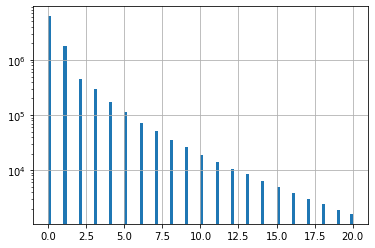

In [25]:
all_df[all_df['is_test']==0]['num_following_pageview'].hist(bins=100, range=(0, 20), log=True)

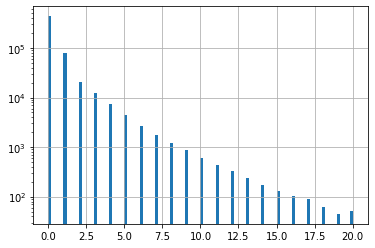

In [26]:
all_df[all_df['is_test']==1]['num_following_pageview'].hist(bins=100, range=(0, 20), log=True)

In [27]:
all_df.columns

Index(['product_action', 'product_sku_hash', 'server_timestamp_epoch_ms',
       'hashed_url', 'is_search', 'is_test', 'SessionId', 'last_event_length',
       'last_hashed_url', 'same_url', 'pageview', 'cum_pageview',
       'cum_product', 'cum_search', 'cum_event', 'first_time', 'lapse',
       'sum_pageview', 'sum_search', 'num_late_pageview', 'num_late_search',
       'session_len_count', 'cum_product_r', 'num_late_search_next',
       'num_late_pageview_next', 'num_following_search',
       'num_following_pageview'],
      dtype='object')

In [28]:
gc.collect()

6169

In [29]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073       16145         228           1        9698       22649
Swap:             0           0           0


In [30]:
for c in ['is_search', 'pageview', 'first_time', 'sum_pageview', 'sum_search',
          'num_late_pageview', 'num_late_search', 'num_late_search_next',
          'num_late_pageview_next', 'session_len_count']:
    if c in all_df.columns:
        del all_df[c]

In [31]:
all_df

,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,is_test,SessionId,last_event_length,last_hashed_url,same_url,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview
0,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,1557247655055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,1,0,14273.0,NaN,False,0,1,0,1,0,0,0.0,0.0
1,detail,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,1556250432707,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,1,1,34160.0,NaN,False,0,1,0,1,0,1,0.0,0.0
2,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,1556250466867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,1,1,34160.0,45adb775d9cb21b5bb8632aca30776bc75eb87c8ee1fd8...,False,0,2,0,2,34160,0,0.0,0.0
3,detail,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,1556994857564,81467c9ea68a761857cf36ccf96b14d04bd8cb34d89f65...,1,2,24601.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,5,1,0,6,66355,3,0.0,1.0
4,detail,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,1556994909153,844e0ffaba1166cf5340747060e926980d858d8226a0fb...,1,2,46543.0,d3ef0deee336c18503ae1151bdc85cab07984481cea916...,False,6,2,0,8,117944,2,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853693,detail,a532a9b9d11dcb3358677f9ff2d41d95f015331acbd632...,1550718210565,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,0,5553722,14933.0,f07a44501e94ddb9296c7dea9df4772382f0715c313810...,False,6,8,0,14,375053,4,0.0,0.0
9853694,detail,3011fe75d8739f217851a68d4c7ab40cce7dd5031f9080...,1550718249795,53c2241664874b9e7e05515c282bc33ae6665641a985f0...,0,5553722,39230.0,369bf5eafd30de4ae1eb0c8f0a55c660266dccd85f5939...,False,6,9,0,15,414283,3,0.0,11.0
9853695,detail,ea950a72ea131ef7181c7dd03f1ed77396648060c1e9cd...,1550718557956,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,0,5553722,22536.0,189a154674efcb6ab196fd1f5341be5b3fd5cf4422bf0f...,False,17,10,0,27,722444,2,0.0,0.0
9853696,detail,bed8a2b601108932cbd8b3b14cde1d4919262c60b35cad...,1550718613724,0ca76955e075818c7eadaafddd0d7b565260fc83e84e06...,0,5553722,55768.0,400a4ea44e23f4cfec9e8129d84a9cb90a0cffecbb5406...,False,17,11,0,28,778212,1,0.0,0.0


In [32]:
%%time
all_df.to_csv(input_path / 'product_train_and_test_4.csv', index=False)

CPU times: user 1min 32s, sys: 2.69 s, total: 1min 35s
Wall time: 2min 10s
